**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions.

**Note: code results are slightly different to written numbers because code was re-run again before GitHub upload**

In [1]:
#Install Objax
!pip --quiet install  objax
import objax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random
import matplotlib.pyplot as plt

##**Part 1. Building a CNN**

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [3]:
#.load_data() by default returns a split between training and test set.
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
# print(X_train.shape, X_test.shape)
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()
# print(X_train.shape, X_test.shape)

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

170498071/170498071 [==============================] - 4s 0us/step


### **Part 1:** *Question 1*

In the code box above, we split the data into training, validation, and test sets. The ration of the split is 8:1:1 (respectively).

The batch size is the total number of examples in each batch. The number of iterations is the number of batches required to complete an epoch. Since we have 48000 data points in the training set, it will take 1500 iterations.

An epoch is the number of iterations required to train the entire dataset, therefore it would take 1500*30 = 45000 iterations for 30 epochs.


Next we will construct a **Base Model**, which in our case is a small CNN.

In [4]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()
# model.vars() # uncomment this line to examine the architecture ##### Part 1 Q1

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns.



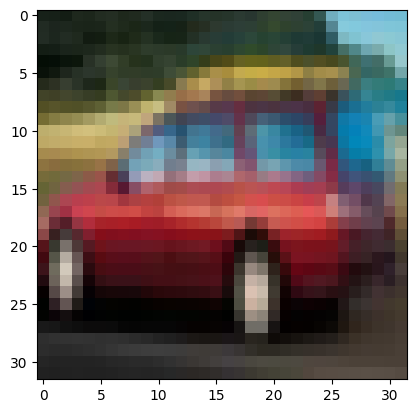

In [5]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output.

In [6]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: [[[[ 0.7304995   0.6803058 ]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]]
Conv output: [[[[-0.10271908 -0.10010862 -0.09076816 ... -0.7420423  -0.73912483
    -0.7374622 ]
   [-0.12882358 -0.11180528 -0.11687267 ... -0.73105437 -0.7434611
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.6991137  -0.7174033
    -0.7156083 ]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.11178758 -0.11439803
    -0.12222939]
   [-0.09658667 -0.09136578 -0.09136578 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353443 -0.08614487 ... -0.16399662 -0.16138618
    -0.15355481]]

  [[ 0.10279882  0.0982345   0.08189839 ...  0.75253254  0.7320599
     0.7214626 ]
   [ 0.14844204  0.1263671   0.1275416  ...  0.77934486  0.7626404
     0.7580761 ]
   [ 0.15300636  0.12562042  0.15036322 ...  0.79253834  0.77845234
     0.775332  ]
   ...
   [ 0.20083015  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799   0.

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [7]:
#Solution to the above problem
def my_conv_net(my_image, initial_filter_weights):
  outputHeight = my_image.shape[2] - initial_filter_weights.shape[0] + 1
  outputWeight = my_image.shape[3] - initial_filter_weights.shape[1] + 1

  my_conv_output = np.zeros([my_image.shape[0], initial_filter_weights.shape[3], outputHeight, outputWeight])


  for numEx in range(0,my_conv_output.shape[0]):
    for numCh in range(my_conv_output.shape[1]):
      for i in range(my_conv_output.shape[2]):
        for j in range(my_conv_output.shape[3]):
          my_conv_output[numEx, numCh, i, j] = np.multiply(my_image[numEx,:,i,j], initial_filter_weights[:,:,:,numCh]).sum()

  return my_conv_output

my_conv_output = my_conv_net(my_image, filter_weights)
print(my_conv_output)
print(my_conv_output.shape)

[[[[-0.10271907 -0.10010862 -0.09076816 ... -0.74204231 -0.73912485
    -0.73746224]
   [-0.12882357 -0.11180527 -0.11687266 ... -0.7310544  -0.74346105
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.69911371 -0.71740328
    -0.71560835]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.1117876  -0.11439805
    -0.1222294 ]
   [-0.09658667 -0.09136577 -0.09136577 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353442 -0.08614487 ... -0.16399661 -0.16138616
    -0.15355481]]

  [[ 0.10279882  0.09823449  0.08189839 ...  0.75253252  0.7320599
     0.72146261]
   [ 0.14844203  0.12636711  0.1275416  ...  0.77934483  0.7626404
     0.75807608]
   [ 0.15300635  0.12562042  0.15036321 ...  0.79253835  0.77845234
     0.77533194]
   ...
   [ 0.20083014  0.1917015   0.1917015  ...  0.27218535  0.27674967
     0.29044263]
   [ 0.16887989  0.15975125  0.15975125 ...  0.29957127  0.29500695
     0.29500695]
   [ 0.15062261  0.14605828  0.15062261 ...  0.3634


### **Part 1:** *Question 2*

Aside from small rounding errors, the code for my custom convolution filter returns the same output as Objax's own convolution routine.

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer.

In [8]:
#Check that .mean((2,3)) rearranges your image
my_conv_output.mean((2,3))

array([[-0.1400071 ,  0.35388902]])

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.**



In [9]:
# Objax's Own Linear Layer
objOutput = my_conv_output.mean((2,3))

objax_linear_layer = objax.nn.Linear(objOutput.shape[1], 1)

x = objOutput
y = objax_linear_layer(objOutput)
b = objax_linear_layer.b.value
w = objax_linear_layer.w.value

# My Layer
myMethod = np.sum(np.multiply(w.T, x)) + b[0]

print(y[0][0])
print(myMethod)

0.034715444
0.034715448


### **Part 1:** *Question 3*

Aside from small rounding errors, the code for my linear layer returns the same output as passing through Objax's own linear routine.

### **Part 1:** *Question 4*
*Explain in a short paragraph what is the difference between the training and validation set.*

The training set is typically the largest (sized) set. This data is used to find the parameters of our model. The validation set, on the other hand, is used for hyper-parameter tuning and model selection - it is a sample of data that provides an unbiased evaluation of the fit of the model. This data is not used to train our model.

You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, *the optimizer and batch sampling routine are left for you to implement.* Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

### **Part 2:** *Question 1*

Completing the optimizer

In [10]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      params.assign(params.value - lr*grad)
      ####################
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

### **Part 2:** *Question 2*

Completing the batch sampling code

In [11]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          ####################
          batch = train_indices[it:it+BATCH]
          ####################
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          ####################
          batch = val_indices[it:it+BATCH]
          ####################
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

### **Part 2:** *Question 3*

Train the model for a few epochs, observe the training/validation loss and training/validation accuracy plots.

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.88 Validation Accuracy 10.03
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.78 Validation Accuracy 10.02
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.90 Validation Accuracy 10.32
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.52 Validation Accuracy 10.58
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.49 Validation Accuracy 11.25
Epoch 0006  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 10.77
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 11.62
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.50 Validation Accuracy 12.08
Epoch 0009  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 11.84 Validation Accuracy 12.25
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 12.33 Validatio

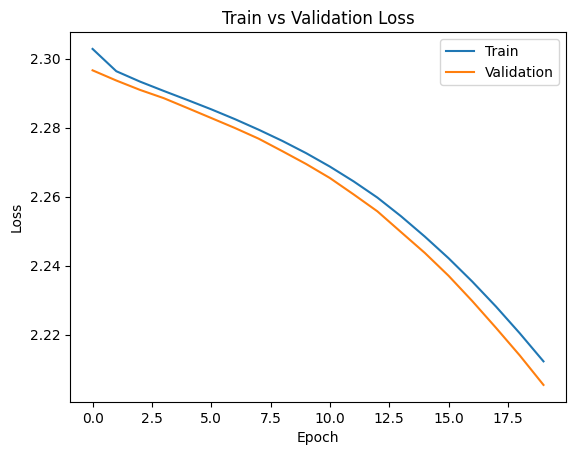

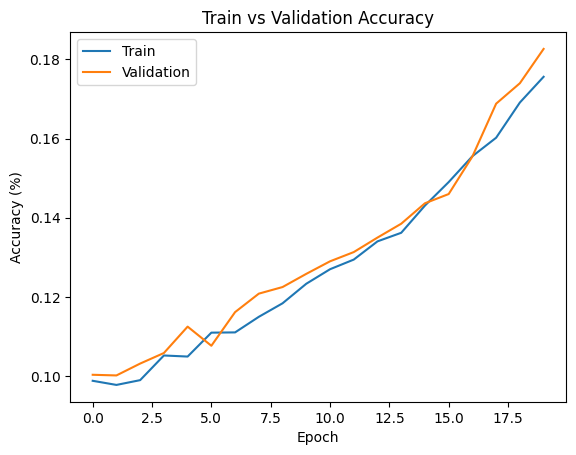

In [12]:
train()

Follow the assignment handout for questions to be answered in this part of the assignment.

### **Part 2:** *Question 4*

*What is the definition of a hyperparameter?*

A hyperparameter is a parameter that is used to control the learning process (unlike model parameters, hyperparameters aren't included in the training itself and can be set by the user before training the model).

*Why is it important not to evaluate the accuracy on the test set until all hyperparameters have been tuned?*

Hyperparameters are very influencial on a training model, impacting the model's convergence and accuracy. During lecture 04 (on October 4th), we were taught how ignoring the validation step (hyperparameter tuning) can lead to overfitting to the test data. Validation metrics can often prevent overfitting because they trend upwards until the model is impacted by overfitting. The best way to complete the process is to train the data, tune all of the hyperparameters and find the best performance on the validation dataset, then evaluate the chosen model against the test dataset. Since the test set is not shown to the model until all of the hyperparameters have been tuned, we avoid overfitting to the test data.

### **Part 2:** *Question 5*

List of 4 Selected Hyperparameters:
1.   Epochs (E)
2.   Learning rate (LR)
3.   Batch size (BS)
4.   Number of outputs of first convolution layer (O)

Two Different Sets of Hyperparameters:

H = {Epochs, Learning rate, batch size, number of outputs of first conv layer}

H  =  { E , LR , BS , O }

H1 = {10, 0.01, 32, 8}

H2 = {20, 0.001, 64, 16}



### **Part2:** *Question 6 (Code Portion)*


Epoch 0001  Training Loss 2.29 Validation Loss 2.25 Training Accuracy 14.38 Validation Accuracy 17.00
Epoch 0002  Training Loss 2.19 Validation Loss 2.13 Training Accuracy 19.01 Validation Accuracy 19.22
Epoch 0003  Training Loss 2.11 Validation Loss 2.09 Training Accuracy 21.02 Validation Accuracy 21.83
Epoch 0004  Training Loss 2.09 Validation Loss 2.08 Training Accuracy 22.16 Validation Accuracy 22.43
Epoch 0005  Training Loss 2.08 Validation Loss 2.08 Training Accuracy 23.14 Validation Accuracy 23.48
Epoch 0006  Training Loss 2.08 Validation Loss 2.07 Training Accuracy 24.12 Validation Accuracy 23.12
Epoch 0007  Training Loss 2.07 Validation Loss 2.06 Training Accuracy 24.52 Validation Accuracy 24.17
Epoch 0008  Training Loss 2.06 Validation Loss 2.05 Training Accuracy 25.16 Validation Accuracy 24.63
Epoch 0009  Training Loss 2.05 Validation Loss 2.04 Training Accuracy 25.77 Validation Accuracy 25.58
Epoch 0010  Training Loss 2.04 Validation Loss 2.03 Training Accuracy 26.41 Valida

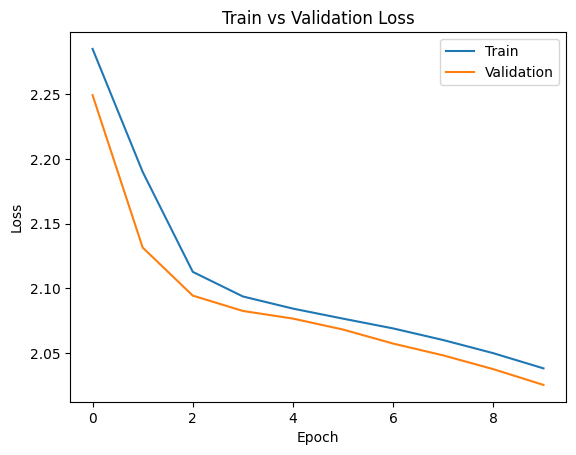

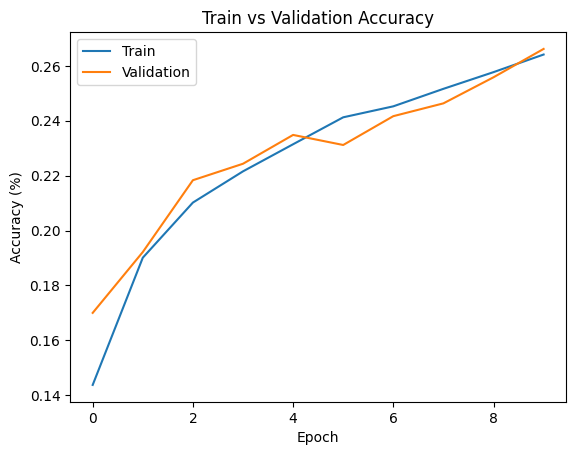

In [13]:
# ------------------------------- MODEL 1 ----------------------------------------
class ConvNet(objax.Module): ## code adapted from part 1
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 8, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(8, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

m1 = ConvNet()

def loss_function(x, labels): ## code adapted from part 2 question 1
    logit = m1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(m1(x)), m1.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, m1.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in m1.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

train(EPOCHS=10, BATCH=32, LEARNING_RATE=0.01)

Epoch 0001  Training Loss 2.33 Validation Loss 2.31 Training Accuracy 10.03 Validation Accuracy 9.32
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.33 Validation Accuracy 11.55
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 11.54 Validation Accuracy 12.77
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 12.64 Validation Accuracy 12.83
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 12.87 Validation Accuracy 13.13
Epoch 0006  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 12.95 Validation Accuracy 13.73
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 13.47 Validation Accuracy 13.82
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 13.85 Validation Accuracy 14.13
Epoch 0009  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 14.24 Validation Accuracy 14.17
Epoch 0010  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 14.05 Validat

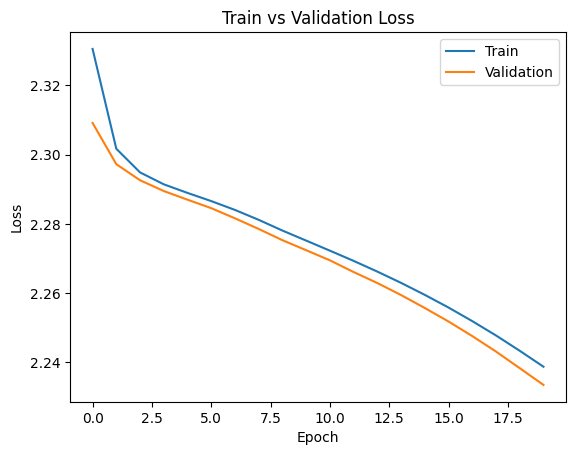

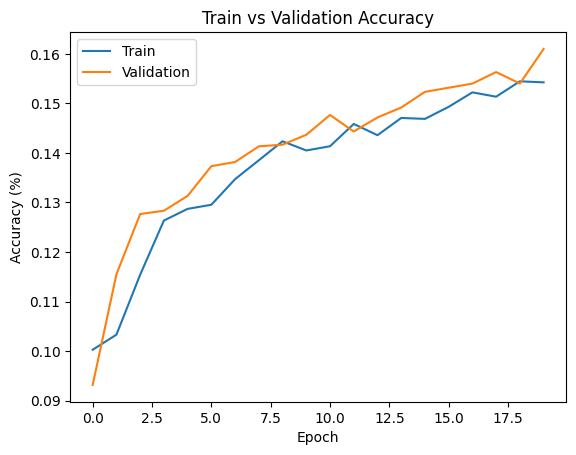

In [14]:
# ------------------------------- MODEL 2 ----------------------------------------
class ConvNet(objax.Module): ## code adapted from part 1
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

m2 = ConvNet()

def loss_function(x, labels): ## code adapted from part 2 question 1
    logit = m2(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(m2(x)), m2.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, m2.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in m2.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

train(EPOCHS=20, BATCH=64, LEARNING_RATE=0.001)

### **Part 2:** *Question 6 (Written Portion)*

Note: When writing the answers to this question, I used the results from the model that are captured in the screenshots submitted to crowdmark.

Base Model (from Q3): 18.27% at EPOCH 20

M1: 26.63% at EPOCH 10

M2: 16.48% at EPOCH 20

**Model 1** performs the best in terms of validation accuracy. The hyperparameters for model one were:

1.   Epochs: 10
2.   Learning rate: 0.01
3. Batch size: 32
4. Outputs of first convolution layer: 8



### **Part 2:** *Question 7*

When considering the three models, I pick model one as my final model. Not only is it the best in terms of validation accuracy, but it also performs better with respect to the other three metrics as well. In order to confirm this decision, the model must be evaluated against the test set. The code and result for this can be seen below.

Based on the results below, the model has the highest test accuracy at epoch 9 with 24.90%. This result is relatively close to the validation set (only 1.73% lower).

Epoch 0001  Training Loss 2.29 Test Loss 2.28 Training Accuracy 12.69 Test Accuracy 15.48
Epoch 0002  Training Loss 2.24 Test Loss 2.19 Training Accuracy 17.31 Test Accuracy 17.57
Epoch 0003  Training Loss 2.14 Test Loss 2.12 Training Accuracy 19.83 Test Accuracy 19.45
Epoch 0004  Training Loss 2.10 Test Loss 2.10 Training Accuracy 21.66 Test Accuracy 21.35
Epoch 0005  Training Loss 2.08 Test Loss 2.08 Training Accuracy 23.02 Test Accuracy 22.75
Epoch 0006  Training Loss 2.07 Test Loss 2.07 Training Accuracy 24.23 Test Accuracy 24.02
Epoch 0007  Training Loss 2.06 Test Loss 2.06 Training Accuracy 25.63 Test Accuracy 22.72
Epoch 0008  Training Loss 2.04 Test Loss 2.04 Training Accuracy 26.89 Test Accuracy 26.22
Epoch 0009  Training Loss 2.02 Test Loss 2.02 Training Accuracy 28.10 Test Accuracy 24.22
Epoch 0010  Training Loss 1.99 Test Loss 2.00 Training Accuracy 28.67 Test Accuracy 26.47


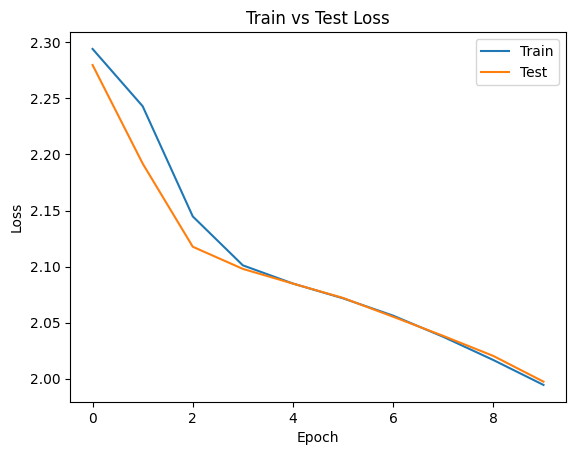

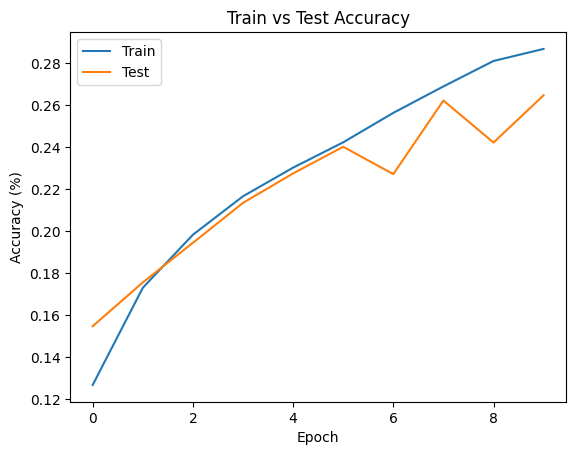

In [15]:
# ------------------------------- MODEL 1 ON TEST DATA ----------------------------------------
class ConvNet(objax.Module): ## code adapted from part 1
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 8, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(8, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

m1 = ConvNet()

def loss_function(x, labels): ## code adapted from part 2 question 1
    logit = m1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(m1(x)), m1.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, m1.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in m1.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_test_loss_epoch = []
  train_acc_epoch = []
  test_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_test_loss =  0  # (averaged) test loss per batch
      train_acc = 0      # training accuracy per batch
      test_acc = 0        # test accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          ####################
          batch = train_indices[it:it+BATCH]
          ####################
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run test
      test_indices = np.arange(len(X_test))
      np.random.shuffle(test_indices)
      for it in range(0, X_test.shape[0], BATCH):
          ####################
          batch = test_indices[it:it+BATCH]
          ####################
          avg_test_loss += float(loss_function(X_test[batch], Y_test[batch])) * len(batch)
          test_prediction = predict(X_test[batch]).argmax(1)
          test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
      test_acc_epoch.append(test_acc/X_test.shape[0])
      avg_test_loss_epoch.append(avg_test_loss/X_test.shape[0])

      print('Epoch %04d  Training Loss %.2f Test Loss %.2f Training Accuracy %.2f Test Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_test_loss/X_test.shape[0], 100*train_acc/X_train.shape[0], 100*test_acc/X_test.shape[0]))

  #Plot training loss
  plt.title("Train vs Test Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_test_loss_epoch, label="Test")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Test Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(test_acc_epoch, label="Test")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

train(EPOCHS=10, BATCH=32, LEARNING_RATE=0.01)

You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


### **Part 3:** *Question 1*
Here, I have followed the code from part one however I have decided to use a new ratio to partition the data. Here, the ratio will be 75:15:15. Initially, I tried to upload the fashion_mnist dataset however I ran into an error I could not overcome. Instead, I used the mnist dataset since we are more familiar with it.

In [16]:
#.load_data() by default returns a split between training and test set.
# We then adjust the training set into a format that can be accepted by our CNN
# In this part, I will be using data from the fashion_mnist dataset

(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert Y_train.shape == (60000,)
assert Y_test.shape == (10000,)

X_train = X_train[:,None,:,:]
X_test = X_test[:,None,:,:]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Y_train = Y_train.flatten()
Y_test = Y_test.flatten()


np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.10
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

4422102/4422102 [==============================] - 0s 0us/step


### **Part 3:**  *Question 2*
Create a base model to start out with

In [17]:
class ConvNet(objax.Module): ## code adapted from part 1
  def __init__(self, number_of_channels = 1, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
newModel = ConvNet()

#You can examine the architecture of our CNN by calling model.vars()
# newModel.vars()

In [18]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = newModel(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(newModel(x)), newModel.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, newModel.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in newModel.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      params.assign(params.value - lr*grad)
      ####################
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

Epoch 0001  Training Loss 6.80 Validation Loss 2.32 Training Accuracy 11.62 Validation Accuracy 9.93
Epoch 0002  Training Loss 2.31 Validation Loss 2.31 Training Accuracy 12.67 Validation Accuracy 9.89
Epoch 0003  Training Loss 2.31 Validation Loss 2.31 Training Accuracy 12.69 Validation Accuracy 9.97
Epoch 0004  Training Loss 2.31 Validation Loss 2.31 Training Accuracy 12.91 Validation Accuracy 9.91
Epoch 0005  Training Loss 2.31 Validation Loss 2.31 Training Accuracy 12.98 Validation Accuracy 9.81
Epoch 0006  Training Loss 2.31 Validation Loss 2.31 Training Accuracy 12.75 Validation Accuracy 10.27
Epoch 0007  Training Loss 2.31 Validation Loss 2.31 Training Accuracy 12.87 Validation Accuracy 10.11
Epoch 0008  Training Loss 2.31 Validation Loss 2.31 Training Accuracy 12.85 Validation Accuracy 10.54
Epoch 0009  Training Loss 2.31 Validation Loss 2.31 Training Accuracy 12.96 Validation Accuracy 10.27
Epoch 0010  Training Loss 2.31 Validation Loss 2.31 Training Accuracy 12.82 Validation 

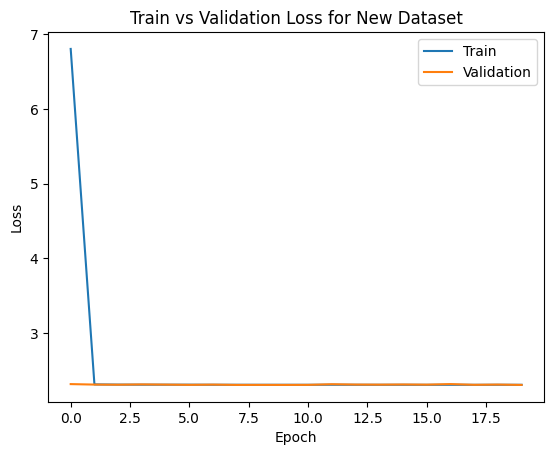

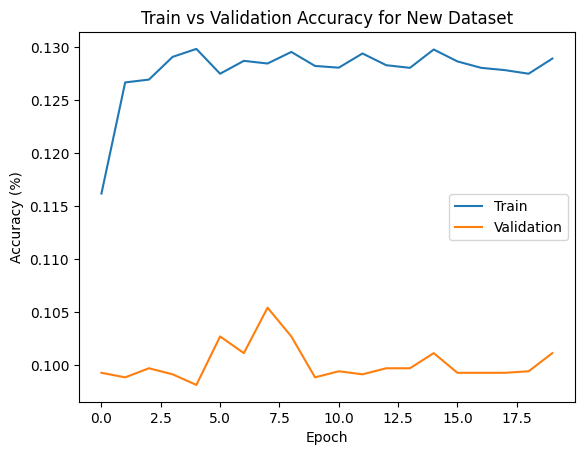

In [19]:
def train(EPOCHS = 20, BATCH = 128, LEARNING_RATE = 0.1):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          ####################
          batch = train_indices[it:it+BATCH]
          ####################
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          ####################
          batch = val_indices[it:it+BATCH]
          ####################
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss for New Dataset")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy for New Dataset")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

train()

### **Part 3:** *Question 3*
The initial model produced by question 2 did not perform well. The training and validation accuracies were very low, and the dispersion of data on the graph was very sporadic. There are three hyperparameters I am going to tune.

Firstly, I reduced the number of epochs. The logic behind this decision is that too many epochs could make the model over-fit the training data. I reduced the number of epochs to 10.

The second change I made was reducing the batch size to 16. Although this caused the validation accuracy to decrease, I conducted research into the relationship between batch size and learning rate in order to fix this problem. According to the article cited below, there is correlation between the batch size and lerning rate: smaller learning rates perform better with smaller batch sizes [1]. Consequently, I increased the learning rate to 0.001.

The tuning described above caused the validation accuracy to increase from 20.69 to 34.16 (for epoch 10). This increase was above the requested 5-10% range, therefore I concluded tuning. The final chosen hyperparameteres were:
- batch size: 80
- number of epochs: 10
- learning rate: 0.001

-




**Source: [1]** https://www.sciencedirect.com/science/article/pii/S2405959519303455

*Article Name:* The effect of batch size on the generalizability of the convolutional neural networks on a histopathology dataset

*Authors:* Ibrahem Kandel, Mauro Castelli


Epoch 0001  Training Loss 1.54 Validation Loss 1.06 Training Accuracy 58.46 Validation Accuracy 63.23
Epoch 0002  Training Loss 1.03 Validation Loss 0.98 Training Accuracy 71.51 Validation Accuracy 65.26
Epoch 0003  Training Loss 0.95 Validation Loss 0.93 Training Accuracy 73.76 Validation Accuracy 68.17
Epoch 0004  Training Loss 0.91 Validation Loss 0.88 Training Accuracy 75.09 Validation Accuracy 69.83
Epoch 0005  Training Loss 0.87 Validation Loss 0.83 Training Accuracy 76.22 Validation Accuracy 71.30
Epoch 0006  Training Loss 0.84 Validation Loss 0.81 Training Accuracy 77.16 Validation Accuracy 72.63
Epoch 0007  Training Loss 0.81 Validation Loss 0.86 Training Accuracy 77.98 Validation Accuracy 69.54
Epoch 0008  Training Loss 0.78 Validation Loss 0.80 Training Accuracy 79.01 Validation Accuracy 71.14
Epoch 0009  Training Loss 0.76 Validation Loss 0.74 Training Accuracy 79.56 Validation Accuracy 74.74
Epoch 0010  Training Loss 0.75 Validation Loss 0.77 Training Accuracy 80.05 Valida

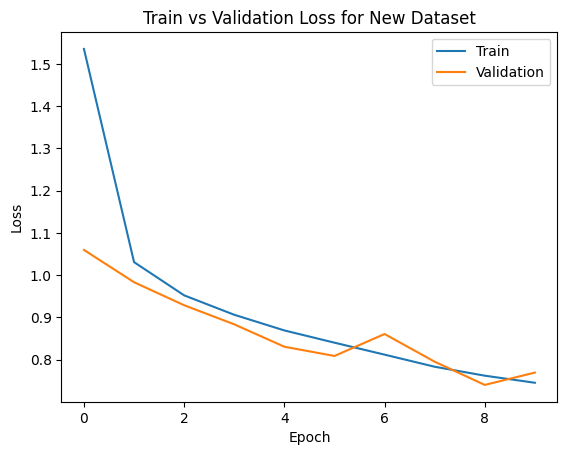

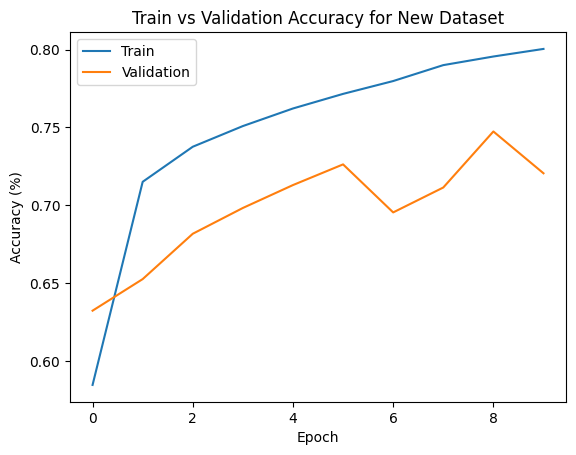

In [20]:
# ------------------------------- UPDATED MODEL ----------------------------------------
class ConvNet(objax.Module): ## code adapted from part 1
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

m1 = ConvNet()

def loss_function(x, labels): ## code adapted from part 2 question 1
    logit = m1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(m1(x)), m1.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, m1.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in m1.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

train(EPOCHS = 10, BATCH = 16, LEARNING_RATE = 0.001)

### **Part 3:** *Question 4*
Below, we can see the code from the model chosen in question 3 evaluated against the test data. The test accuracy remains relatively similar to the validation accuracy, therefore I am confident in this model. The highest test accuracy was 32.24 and the test accuracy for epoch 10 (corresponding to the highest validation accuracy) was 31.37.

Epoch 0001  Training Loss 1.50 Test Loss 1.07 Training Accuracy 59.98 Test Accuracy 64.89
Epoch 0002  Training Loss 1.00 Test Loss 0.93 Training Accuracy 73.10 Test Accuracy 69.14
Epoch 0003  Training Loss 0.89 Test Loss 0.84 Training Accuracy 75.54 Test Accuracy 72.29
Epoch 0004  Training Loss 0.83 Test Loss 0.82 Training Accuracy 77.16 Test Accuracy 71.53
Epoch 0005  Training Loss 0.80 Test Loss 0.82 Training Accuracy 77.94 Test Accuracy 71.64
Epoch 0006  Training Loss 0.77 Test Loss 0.78 Training Accuracy 78.87 Test Accuracy 73.04
Epoch 0007  Training Loss 0.75 Test Loss 0.77 Training Accuracy 79.25 Test Accuracy 74.49
Epoch 0008  Training Loss 0.73 Test Loss 0.75 Training Accuracy 79.79 Test Accuracy 74.51
Epoch 0009  Training Loss 0.72 Test Loss 0.75 Training Accuracy 80.21 Test Accuracy 74.29
Epoch 0010  Training Loss 0.70 Test Loss 0.75 Training Accuracy 80.55 Test Accuracy 73.59


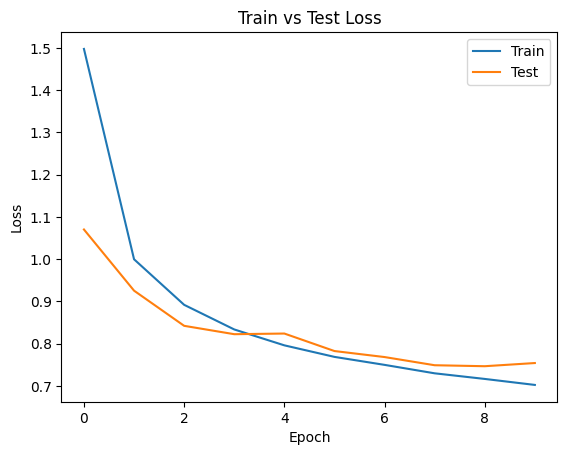

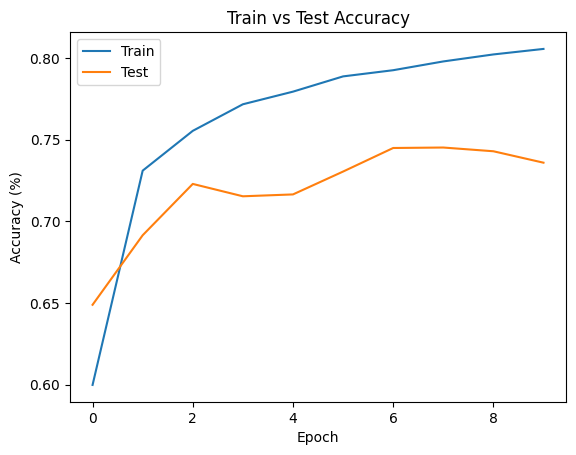

In [21]:
# ------------------------------- MODEL 1 ON TEST DATA ----------------------------------------
class ConvNet(objax.Module): ## code adapted from part 1
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 8, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(8, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

m1 = ConvNet()

def loss_function(x, labels): ## code adapted from part 2 question 1
    logit = m1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(m1(x)), m1.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, m1.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in m1.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

def train(EPOCHS = 10, BATCH = 80, LEARNING_RATE = 9e-2):
  avg_train_loss_epoch = []
  avg_test_loss_epoch = []
  train_acc_epoch = []
  test_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_test_loss =  0  # (averaged) test loss per batch
      train_acc = 0      # training accuracy per batch
      test_acc = 0        # test accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          ####################
          batch = train_indices[it:it+BATCH]
          ####################
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run test
      test_indices = np.arange(len(X_test))
      np.random.shuffle(test_indices)
      for it in range(0, X_test.shape[0], BATCH):
          ####################
          batch = test_indices[it:it+BATCH]
          ####################
          avg_test_loss += float(loss_function(X_test[batch], Y_test[batch])) * len(batch)
          test_prediction = predict(X_test[batch]).argmax(1)
          test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
      test_acc_epoch.append(test_acc/X_test.shape[0])
      avg_test_loss_epoch.append(avg_test_loss/X_test.shape[0])

      print('Epoch %04d  Training Loss %.2f Test Loss %.2f Training Accuracy %.2f Test Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_test_loss/X_test.shape[0], 100*train_acc/X_train.shape[0], 100*test_acc/X_test.shape[0]))

  #Plot training loss
  plt.title("Train vs Test Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_test_loss_epoch, label="Test")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Test Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(test_acc_epoch, label="Test")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

train(EPOCHS = 10, BATCH = 16, LEARNING_RATE = 0.001)

##**Problem 4:** *Open-Ended Exploration*

For this problem, I will be responding to question #1. Also, I will be building off of my experiment from part 2, further modifying my first model.

Considering the hyperparameters I have tuned in the previous parts, here I will be tuning the number of input channels on the linear batch.

In [22]:
#.load_data() by default returns a split between training and test set.
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
# print(X_train.shape, X_test.shape)
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()
# print(X_train.shape, X_test.shape)

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

In [23]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 1), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 1), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()
# model.vars() # uncomment this line to examine the architecture ##### Part 1 Q1

In [24]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      params.assign(params.value - lr*grad)
      ####################
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [25]:
def train(EPOCHS = 10, BATCH = 32, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          ####################
          batch = train_indices[it:it+BATCH]
          ####################
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          ####################
          batch = val_indices[it:it+BATCH]
          ####################
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()


Epoch 0001  Training Loss 2.29 Validation Loss 2.27 Training Accuracy 11.24 Validation Accuracy 15.27
Epoch 0002  Training Loss 2.25 Validation Loss 2.22 Training Accuracy 17.10 Validation Accuracy 17.62
Epoch 0003  Training Loss 2.19 Validation Loss 2.16 Training Accuracy 18.53 Validation Accuracy 19.37
Epoch 0004  Training Loss 2.14 Validation Loss 2.12 Training Accuracy 20.10 Validation Accuracy 20.88
Epoch 0005  Training Loss 2.11 Validation Loss 2.10 Training Accuracy 21.41 Validation Accuracy 21.65
Epoch 0006  Training Loss 2.10 Validation Loss 2.09 Training Accuracy 22.26 Validation Accuracy 21.93
Epoch 0007  Training Loss 2.09 Validation Loss 2.08 Training Accuracy 22.72 Validation Accuracy 22.72
Epoch 0008  Training Loss 2.08 Validation Loss 2.08 Training Accuracy 23.04 Validation Accuracy 22.58
Epoch 0009  Training Loss 2.08 Validation Loss 2.07 Training Accuracy 23.36 Validation Accuracy 23.88
Epoch 0010  Training Loss 2.07 Validation Loss 2.06 Training Accuracy 23.81 Valida

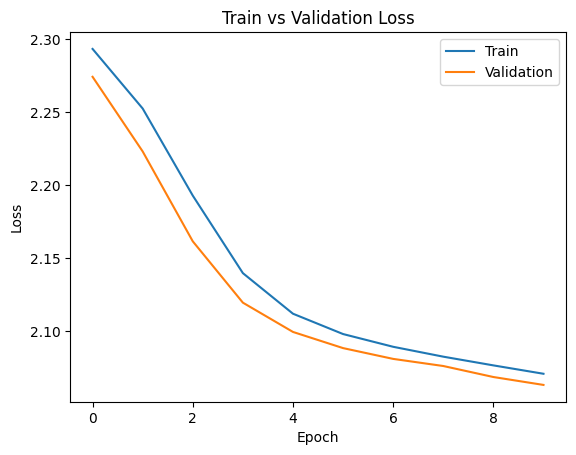

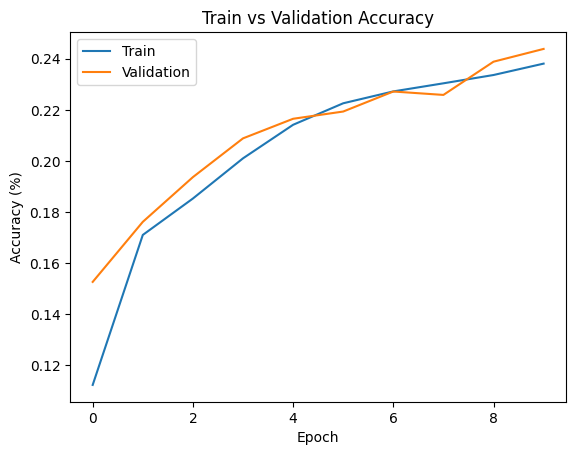

In [26]:
train()